# Time-frequency analysis of EEG signals

author: Carina Forster

contact: forster@cbs.mpg.de

last updated 15.07.2024

Aim: what is the spectral content of the data?

In [1]:
import mne
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:
# get rid of the sometimes excessive logging output
mne.set_log_level('error')

In [2]:
#%matplotlib qt
# we plot the data with matplotlib in the notebook
%matplotlib inline

In [73]:
# load epoched liverpool data (preprocessed)
# make sure to change the path to your directory
data_dir = Path("C:/", "Users", "Carina", "Desktop", "data_liverpool")
# data was re-referenced to FPz
epochs = mne.read_epochs(Path(data_dir, 'liverpool_fpz_reference-epo.fif'))

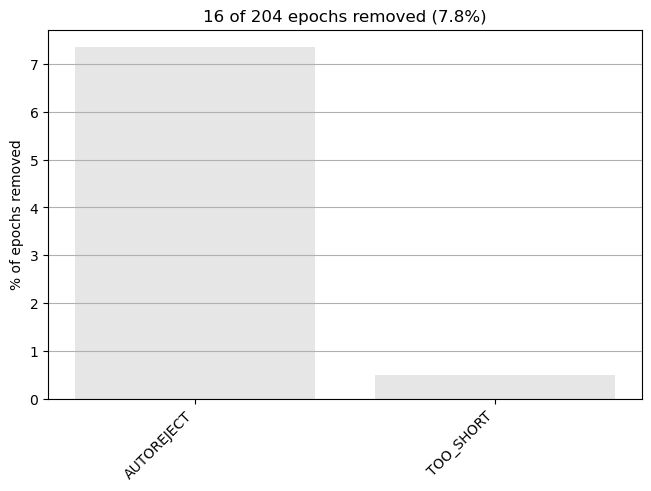

In [4]:
# some epochs were dropped during preprocessing, which is why we can't simply concatenate the epochs to a continuous data array
epochs.plot_drop_log();

In [5]:
# load the clean raw data (continuous)
data_dir = Path("C:/", "Users", "Carina", "Desktop", "data_liverpool")
raw_liv = mne.io.read_raw_fif(Path(data_dir, "liverpool_after_prepro_and_ica-raw.fif"))

Opening raw data file C:\Users\Carina\Desktop\data_liverpool\liverpool_after_prepro_and_ica-raw.fif...
    Range : 0 ... 313343 =      0.000 ...   611.998 secs
Ready.


## Let's look at power averaged over time

In [7]:
# why do we drop Fcz?
spectrum_epochs = epochs.drop_channels(['FCz']).compute_psd(fmin=1, fmax=40)
# for the liverpool data we use the continuous data instead of epochs
spectrum_raw = raw_liv.compute_psd(fmin=2, fmax=40)

    Using multitaper spectrum estimation with 7 DPSS windows
Effective window size : 4.000 (s)


C:\Users\Carina\AppData\Local\Temp\ipykernel_17784\3525418306.py:2: UserWarning: Zero value in spectrum for channel Fpz
  spectrum_epochs = epochs.drop_channels(['FCz']).compute_psd(fmin=1, fmax=40)


In [8]:
len(spectrum_raw.freqs)

153

c:\Users\Carina\mambaforge\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


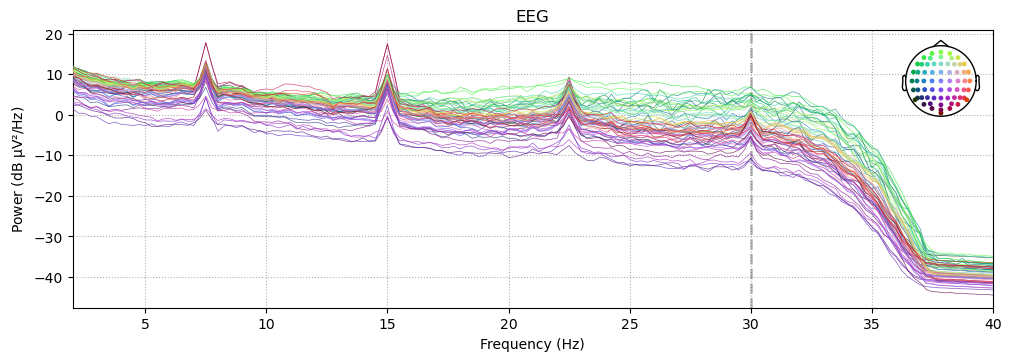

In [13]:
# I recommend decibel scaling for the power spectrum density as you can see the power differences better
spectrum_raw.plot(dB=True);

c:\Users\Carina\mambaforge\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


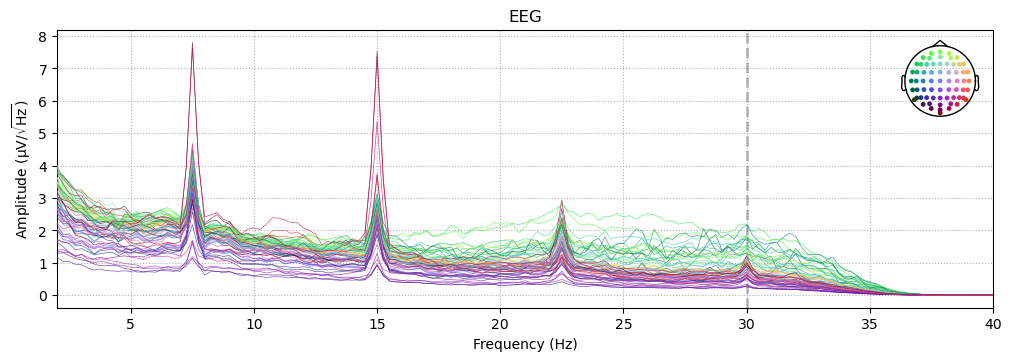

In [14]:
spectrum_raw.plot(dB=False);

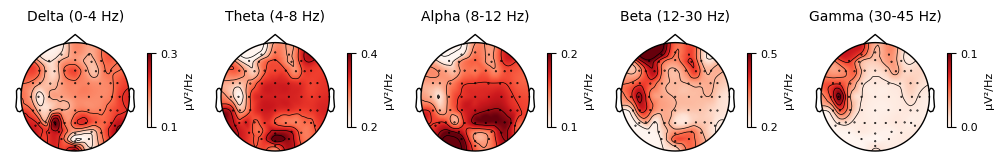

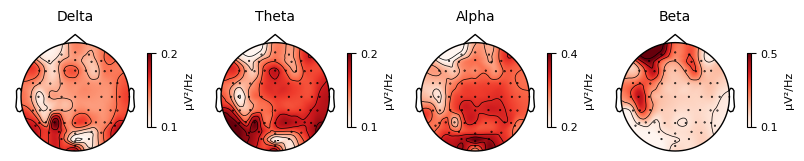

In [21]:
spectrum_raw.plot_topomap(ch_type='eeg', normalize=True, dB=True);


# change the frequency bands to your liking
# the bands are defined in the format (start, stop, name)
bands = [(1, 3, 'Delta'), (3, 6, 'Theta'), (7, 13, 'Alpha'), (15, 30, 'Beta')]
# the power spectrum density is calculated in the function below
spectrum_raw.plot_topomap(ch_type='eeg', normalize=True, dB=True, bands=bands);

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Determine the individual peaks from the PSD

</div>

(64, 153)


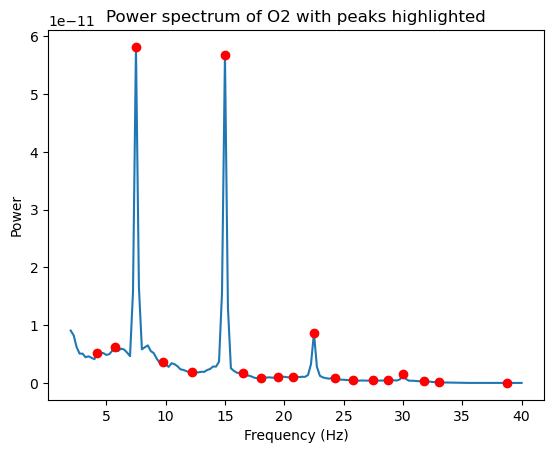

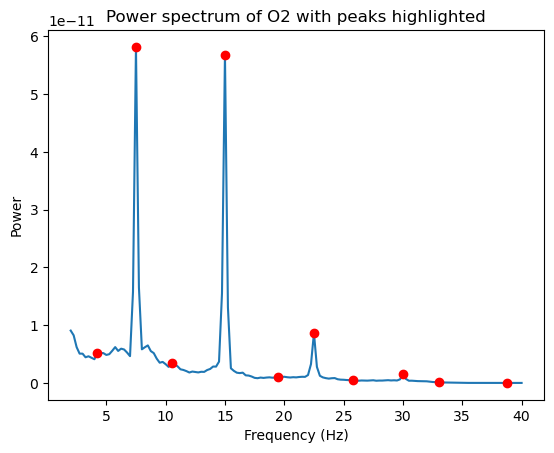

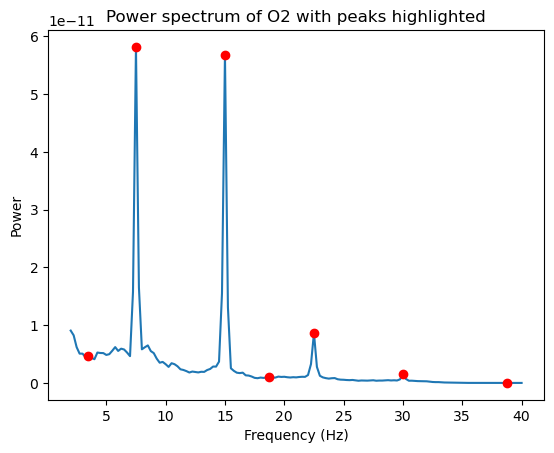

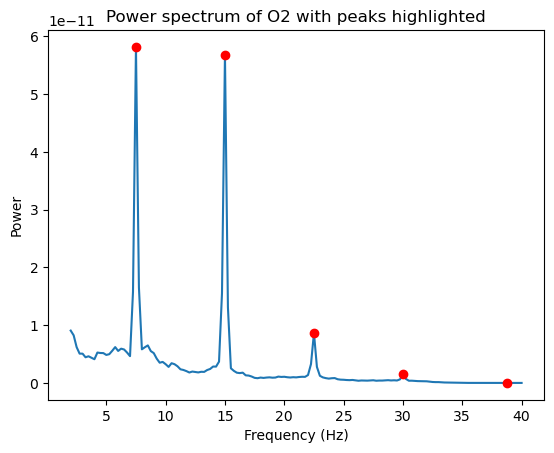

In [59]:
import scipy
import numpy as np

print(spectrum_raw._data.shape)

vis_index = raw_liv.ch_names.index('O2')

# let's pick channel O2
spectrum_vis = spectrum_raw._data[vis_index, :]

# find peaks in the spectrum
peak_vis = scipy.signal.find_peaks(spectrum_vis, distance=15)

# loop over list of distance values to find the best one
for distance in np.arange(5, 25, 5):
    peak_vis = scipy.signal.find_peaks(spectrum_vis, distance=distance)
    # plot the spectrum with the peaks highlighted
    plt.plot(spectrum_raw.freqs, spectrum_vis)
    plt.plot(spectrum_raw.freqs[peak_vis[0]], spectrum_vis[peak_vis[0]], 'ro')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('Power spectrum of O2 with peaks highlighted')
    plt.show()

Bonus:

load the resting state data and determine the individual alpha peak frequency

check out:

https://mne.discourse.group/t/individual-alpha-frequency/1500/2

## But what about time?

### so far we averaged over time and then calculated the power for this time window. 

In [60]:
# let's calculate power over time and frequencies to see whether there are any changes in power over time

# define frequencies
freqs = np.logspace(*np.log10([6, 35]), num=16) # frequency resolution

n_cycles = 7  # number of cycles in Morlet wavelet (fwhm = n_cycles / freq)

# the higher the frequency resolution, the longer the computation takes
power = raw_liv.compute_tfr(
    method="morlet", # could be Multitaper or Welch
    freqs=freqs,
    n_cycles=n_cycles
)

Text(0, 0.5, 'Frequency (Hz)')

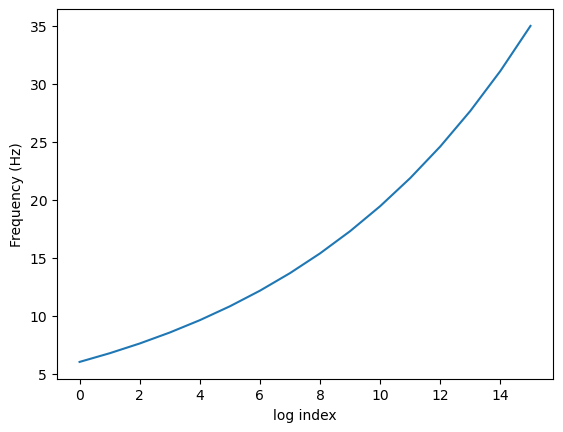

In [64]:
# why would we use log scaling for frequencies?
plt.plot(freqs)
plt.xlabel('log index')
plt.ylabel('Frequency (Hz)')


<div class="alert alert-block alert-info">
<b>Wavelets excurs:</b> 

Wavelets excurs:

The relationship between the number of cycles and temporal precision is an important aspect of time-frequency analysis.


Morlet Wavelets:
- are complex sinusoids modulated by a Gaussian window.

- provide a good balance between time and frequency resolution.


Number of Cycles: 
- how many oscillations of the sinusoidal part of the wavelet fit within the Gaussian window

Temporal Precision: 
- how precisely the wavelet can localize events in time

Frequency Precision: 
- how precisely the wavelet can estimate the events in frequency space.

Relationship Between Cycles and Precision

Low Number of Cycles:

- High Temporal Precision: The wavelet is shorter in duration, allowing it to better localize transient events in time.

- Low Frequency Precision: The wavelet has a broader frequency response, meaning it is less precise in distinguishing between different frequencies.

High Number of Cycles:

- Low Temporal Precision: The wavelet is longer in duration, which means it cannot localize transient events in time as well.
- High Frequency Precision: The wavelet has a narrower frequency response, providing better resolution of different frequencies.

Trade-Off
There is an inherent trade-off between temporal and frequency precision when using Morlet wavelets:

Short Wavelets (few cycles): Good for time localization, but poor for frequency localization.
Long Wavelets (many cycles): Good for frequency localization, but poor for time localization.

Practical Implications

- Analyzing Rapid Transients: Use fewer cycles to achieve better temporal resolution.

- Analyzing Steady-State Oscillations: Use more cycles to achieve better frequency resolution.

</div>

No baseline correction applied


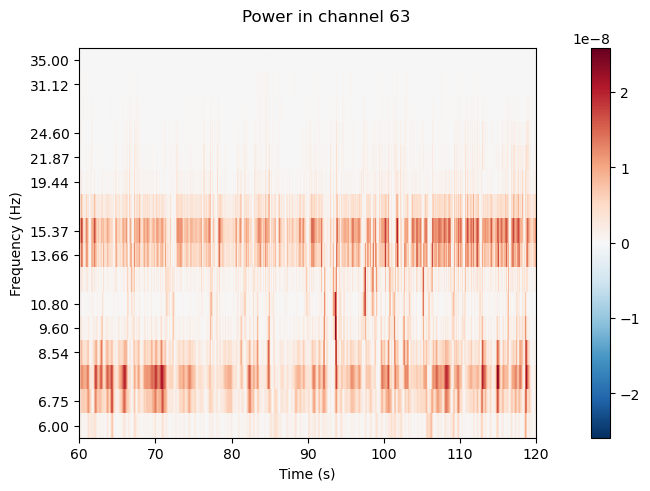

In [42]:
# plot the power in a visual channel over 1 minute
vis_index = raw_liv.ch_names.index('O2')
power.copy().crop(60,120).plot(title=f'Power in channel O2', mode="mean", picks=[vis_index]);
# change the frequency resolution to see how it affects the power calculation
# change the n_cycles parameter to see how it affects the power calculation

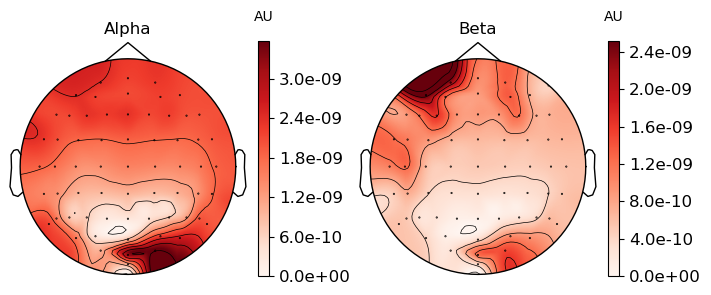

In [66]:
# let's look at the topography of power in the alpha and beta band
fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", show=False
)
plot_dict = dict(Alpha=dict(fmin=7, fmax=13), Beta=dict(fmin=15, fmax=25))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw, show_names=False)
    ax.set_title(title)

## Bonus: What is induced power? 
### Check out this paper by Karl Friston and colleagues for a in-depth discussion 
### [Evoked vs. induced signals](https://www.fil.ion.ucl.ac.uk/~karl/Mechanisms%20of%20evoked%20and%20induced%20responses.pdf)

- transient signal components (phase-locked or evoked components) are part of the TFR
- sometimes one wants to analyze ongoing rhytmic activity only (induced) 

Suggestion: subtract the trial averaged ERP/ERF from the data prior to computing the TFR

However, see [fieldtrip homepage](https://www.fieldtriptoolbox.org/faq/evoked_vs_induced/) for why this might not always work

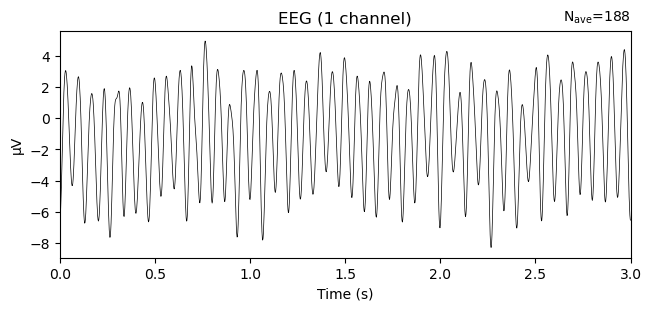

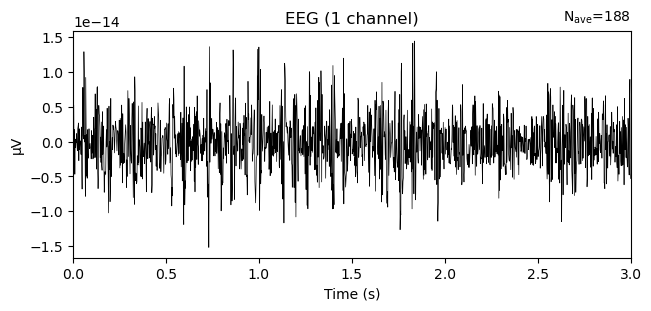

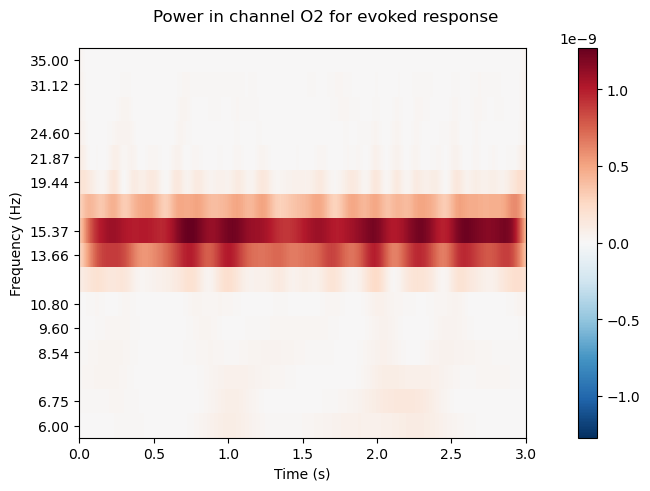

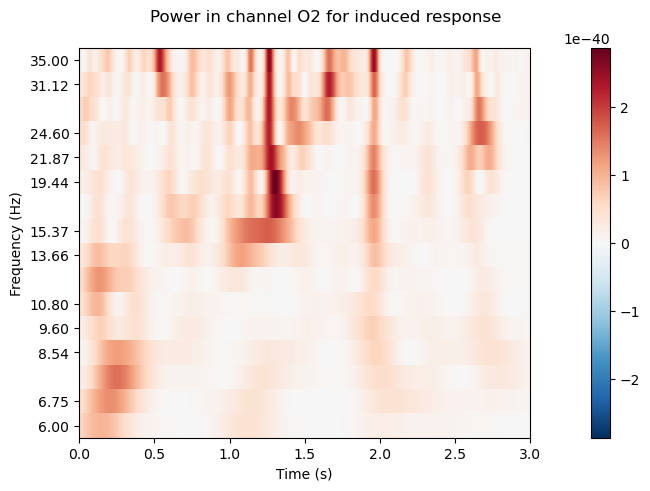

In [75]:
# calculate evoked response
epochs.average().plot(picks='O2');
evoked = epochs.average()

# subtract the evoked response from the epochs
epochs.subtract_evoked().average().plot(picks='O2');
induced = epochs.subtract_evoked().average()

# define frequencies
freqs = np.logspace(*np.log10([6, 35]), num=16) # frequency resolution

n_cycles = 7  # number of cycles in Morlet wavelet (fwhm = n_cycles / freq)

# calculate power for evoked and induced
power_evoked = evoked.compute_tfr(
    method="morlet", # could be Multitaper or Welch
    freqs=freqs,
    n_cycles=n_cycles
)

power_induced = induced.compute_tfr(
    method="morlet", # could be Multitaper or Welch
    freqs=freqs,
    n_cycles=n_cycles
)

# plot the power in a visual channel over 1 minute
power_evoked.plot(title=f'Power in channel O2 for evoked response', mode="mean", picks=[vis_index]);
power_induced.plot(title=f'Power in channel O2 for induced response', mode="mean", picks=[vis_index]);

<div class="alert alert-block alert-warning">
<b>Discussion:</b> 

When do you choose PSD over TFR?

If you have not hypotheses about when power should change over time or no events then a PSD might be enough.

Time-frequency is higher-dimensional, thus more complex regarding the computation and the statistics.


</div>